<a href="https://colab.research.google.com/github/maab2198/nlp2021/blob/labs/lab5/lab5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [14]:
import pandas as pd
import random
import tensorflow as tf 
from matplotlib import pyplot as plt
from tensorflow.keras import layers

from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from tensorflow.keras.layers import Embedding
from tensorflow.keras import Sequential
from sklearn.model_selection import train_test_split

In [ ]:
# Create tensorboard callback (need to create a new one for each model)
from helper_functions import create_tensorboard_callback

In [6]:
path = "drive/My Drive/nlp/lab5/"

In [24]:

from sklearn.metrics import accuracy_score, precision_recall_fscore_support
# Plot the validation and training data separately
import matplotlib.pyplot as plt

def calculate_results(y_true, y_pred):
  """
  Calculates model accuracy, precision, recall and f1 score of a binary classification model.

  Args:
  -----
  y_true = true labels in the form of a 1D array
  y_pred = predicted labels in the form of a 1D array

  Returns a dictionary of accuracy, precision, recall, f1-score.
  """
  # Calculate model accuracy
  model_accuracy = accuracy_score(y_true, y_pred) * 100
  # Calculate model precision, recall and f1 score using "weighted" average
  model_precision, model_recall, model_f1, _ = precision_recall_fscore_support(y_true, y_pred, average="weighted")
  model_results = {"accuracy": model_accuracy,
                  "precision": model_precision,
                  "recall": model_recall,
                  "f1": model_f1}
  return model_results
  

def plot_history(history): 
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'val'], loc='upper left')
    plt.show()

def compare_baseline_to_new_results(baseline_results, new_model_results):
  for key, value in baseline_results.items():
    print(f"Baseline {key}: {value:.2f}, New {key}: {new_model_results[key]:.2f}, Difference: {new_model_results[key]-value:.2f}")


Get text data

In [7]:
siameseData = pd.read_csv(path + "siamese_nn.csv")
emotionData = pd.read_csv(path  + "emotion_recognition.csv",sep=";")
covidData = pd.read_csv(path + "coranavirus_disease.csv",sep=";")
covidData["target"] = 2
emotionData["target"] = 0
train_df = pd.concat([emotionData,covidData, siameseData], ignore_index=True )
train_shuffle=train_df.sample(frac=1,random_state=9) 
train_shuffle.head(10)

,text,target
39,In order to demonstrate the high effectivennes...,0
38,"In this experimental work, we have used Multiv...",0
183,Hao has constructed the ensemble predictor of ...,2
13,. After the last convolutional layer we divide...,0
90,Speech is the main and direct means of transmi...,0
165,Region-wise this distribution depicts total de...,2
44,. It contains 535 utterances spoken by 10 acto...,0
4,The main advantage of DL is the fact that it r...,0
57,The researchers are still debating for what fe...,0
149,"In addition, the introduced method learns to g...",2


In [15]:
train_sentences, test_sentences, train_labels,test_labels = train_test_split(
    train_shuffle['text'].to_numpy(),
    train_shuffle['target'].to_numpy(),
    test_size=0.1, 
    random_state=40
)
max_sq_len = round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))
text_vectorizer = TextVectorization(max_tokens=10000,  #number of word in vocabulary
                                    standardize="lower_and_strip_punctuation", 
                                    split ="whitespace",
                                    output_mode="int",
                                    output_sequence_length=max_sq_len,
                                    pad_to_max_tokens=True)


In [25]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
model_0= Pipeline([ 
    ("tfidf",TfidfVectorizer()), 
    ("clf", MultinomialNB())
])
model_0.fit(train_sentences,train_labels)
model_0_preds =model_0.predict(test_sentences)
model_0_results = calculate_results(test_labels,model_0_preds)


## Model 6: TensorFlow Hub Pretrained Sentence Encoder

In [33]:
url= "https://tfhub.dev/google/universal-sentence-encoder/4"

In [16]:
# Example of pretrained embedding with universal sentence encoder - https://tfhub.dev/google/universal-sentence-encoder/4
import tensorflow_hub as hub

sentence_encoder_layer = hub.KerasLayer(url,
                                        input_shape=[], # shape of inputs coming to our model 
                                        dtype=tf.string, # data type of inputs coming to the USE layer
                                        trainable=False, # keep the pretrained weights (we'll create a feature extractor)
                                        name="USE") 


In [20]:
model_6 = tf.keras.Sequential([
  sentence_encoder_layer, # take in sentences and then encode them into an embedding
  layers.Dense(64, activation="relu"),
  layers.Dense(3, activation="softmax")
], name="model_6_USE")

In [21]:
model_6.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_6.summary()

Model: "model_6_USE"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_4 (Dense)             (None, 64)                32832     
                                                                 
 dense_5 (Dense)             (None, 3)                 195       
                                                                 
Total params: 256,830,851
Trainable params: 33,027
Non-trainable params: 256,797,824
_________________________________________________________________


In [22]:
model_6_history = model_6.fit(train_sentences,
                              train_labels,
                              epochs=5,
                              validation_data=(test_sentences, test_labels))

Epoch 1/5
9/9 [==============================] - 4s 83ms/step - loss: 1.0804 - accuracy: 0.5296 - val_loss: 1.0444 - val_accuracy: 0.7333
Epoch 2/5
9/9 [==============================] - 0s 18ms/step - loss: 0.9958 - accuracy: 0.8815 - val_loss: 0.9795 - val_accuracy: 0.8000
Epoch 3/5
9/9 [==============================] - 0s 19ms/step - loss: 0.9083 - accuracy: 0.9185 - val_loss: 0.8992 - val_accuracy: 0.8667
Epoch 4/5
9/9 [==============================] - 0s 18ms/step - loss: 0.8073 - accuracy: 0.9074 - val_loss: 0.8166 - val_accuracy: 0.8333
Epoch 5/5
9/9 [==============================] - 0s 17ms/step - loss: 0.7078 - accuracy: 0.9111 - val_loss: 0.7382 - val_accuracy: 0.8333


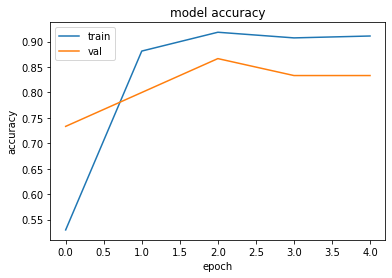

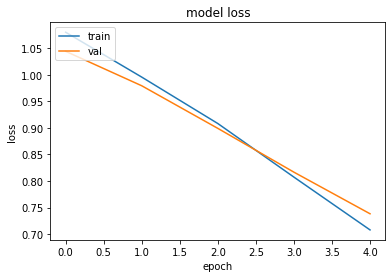

In [27]:
plot_history(model_6_history)

In [28]:
model_6_pred_probs = model_6.predict(test_sentences)
model_6_preds = tf.squeeze(tf.argmax(model_6_pred_probs, axis = 1))
model_6_preds

<tf.Tensor: shape=(30,), dtype=int64, numpy=
array([0, 1, 1, 1, 2, 0, 1, 0, 2, 0, 2, 2, 0, 1, 2, 1, 0, 2, 1, 2, 1, 2,
       1, 1, 1, 2, 0, 1, 1, 1])>

In [30]:
model_6_results = calculate_results(y_true = test_labels, y_pred = model_6_preds)
compare_baseline_to_new_results(model_0_results, model_6_results)

Baseline accuracy: 96.67, New accuracy: 83.33, Difference: -13.33
Baseline precision: 0.97, New precision: 0.87, Difference: -0.10
Baseline recall: 0.97, New recall: 0.83, Difference: -0.13
Baseline f1: 0.97, New f1: 0.83, Difference: -0.14


### Model 7: TensorFlow Hub Pretrained Sentence Encoder 10% of the training data

In [45]:
tf_hub_embedding_layer = hub.KerasLayer(url,
                                        input_shape=[],
                                        dtype=tf.string, 
                                        trainable=True, 
                                        name="USE-FT")

In [46]:
model_7 = tf.keras.Sequential([
  tf_hub_embedding_layer, 
  layers.Dense(64, activation="relu"),
  layers.Dense(3, activation="softmax")
], name="model_7_USE_fine_tuning")

# Compile model
model_7.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


model_7.summary()

Model: "model_7_USE_fine_tuning"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE-FT (KerasLayer)         (None, 512)               256797824 
                                                                 
 dense_10 (Dense)            (None, 64)                32832     
                                                                 
 dense_11 (Dense)            (None, 3)                 195       
                                                                 
Total params: 256,830,851
Trainable params: 256,830,851
Non-trainable params: 0
_________________________________________________________________


In [47]:
model_7_history=model_7.fit(train_sentences,train_labels,
                            epochs=5,
                            validation_data=(test_sentences,test_labels)
                            )

Epoch 1/5
9/9 [==============================] - 29s 2s/step - loss: 1.0429 - accuracy: 0.6037 - val_loss: 0.9538 - val_accuracy: 0.7667
Epoch 2/5
9/9 [==============================] - 21s 2s/step - loss: 0.8343 - accuracy: 0.9222 - val_loss: 0.7918 - val_accuracy: 0.8333
Epoch 3/5
9/9 [==============================] - 21s 2s/step - loss: 0.5735 - accuracy: 0.9556 - val_loss: 0.6258 - val_accuracy: 0.8333
Epoch 4/5
9/9 [==============================] - 21s 2s/step - loss: 0.3159 - accuracy: 0.9852 - val_loss: 0.4738 - val_accuracy: 0.8667
Epoch 5/5
9/9 [==============================] - 21s 2s/step - loss: 0.1346 - accuracy: 0.9963 - val_loss: 0.3837 - val_accuracy: 0.8000


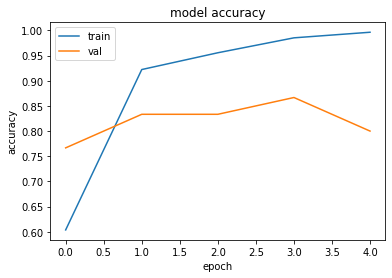

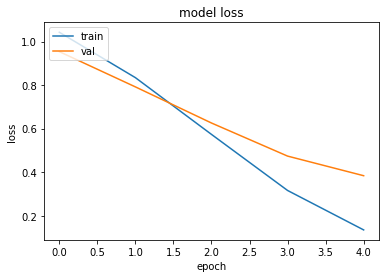

In [48]:
plot_history(model_7_history)

In [49]:
model_7_pred_probs = model_7.predict(test_sentences)
model_7_preds = tf.squeeze(tf.argmax(model_7_pred_probs, axis = 1))
model_7_results = calculate_results(y_true = test_labels, y_pred = model_7_preds)
compare_baseline_to_new_results(model_0_results, model_7_results)

Baseline accuracy: 96.67, New accuracy: 80.00, Difference: -16.67
Baseline precision: 0.97, New precision: 0.80, Difference: -0.17
Baseline recall: 0.97, New recall: 0.80, Difference: -0.17
Baseline f1: 0.97, New f1: 0.80, Difference: -0.17


In [50]:
for layer_number , layer in enumerate(model_7.layers):
  print(layer_number, layer.name, layer.trainable)

0 USE-FT True
1 dense_10 True
2 dense_11 True


In [51]:
tf_hub_embedding_layer.trainable=False
model_8 = tf.keras.Sequential([
  tf_hub_embedding_layer, 
  layers.Dense(64, activation="relu"),
  layers.Dense(3, activation="softmax")
], name="model_8_USE_FT_Not_trainable")


model_8.compile(loss="sparse_categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])


model_8.summary()

Model: "model_8_USE_FT_Not_trainable"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE-FT (KerasLayer)         (None, 512)               256797824 
                                                                 
 dense_12 (Dense)            (None, 64)                32832     
                                                                 
 dense_13 (Dense)            (None, 3)                 195       
                                                                 
Total params: 256,830,851
Trainable params: 33,027
Non-trainable params: 256,797,824
_________________________________________________________________


In [53]:
model_8_history = model_8.fit(train_sentences,train_labels,epochs=5,
                        validation_data=(test_sentences,test_labels))

Epoch 1/5
9/9 [==============================] - 0s 21ms/step - loss: 0.0776 - accuracy: 1.0000 - val_loss: 0.3764 - val_accuracy: 0.8333
Epoch 2/5
9/9 [==============================] - 0s 19ms/step - loss: 0.0511 - accuracy: 1.0000 - val_loss: 0.3599 - val_accuracy: 0.8333
Epoch 3/5
9/9 [==============================] - 0s 18ms/step - loss: 0.0368 - accuracy: 1.0000 - val_loss: 0.3505 - val_accuracy: 0.8333
Epoch 4/5
9/9 [==============================] - 0s 18ms/step - loss: 0.0282 - accuracy: 1.0000 - val_loss: 0.3450 - val_accuracy: 0.8333
Epoch 5/5
9/9 [==============================] - 0s 18ms/step - loss: 0.0228 - accuracy: 1.0000 - val_loss: 0.3418 - val_accuracy: 0.8333


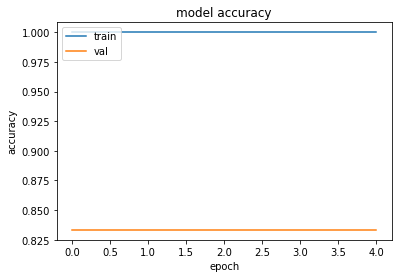

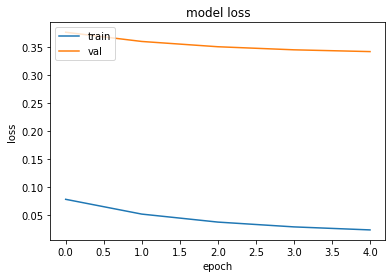

In [54]:
plot_history(model_8_history)

In [55]:
model_8_pred_probs = model_8.predict(test_sentences)
model_8_preds = tf.squeeze(tf.argmax(model_8_pred_probs, axis = 1))
model_8_results = calculate_results(y_true = test_labels, y_pred = model_8_preds)
compare_baseline_to_new_results(model_0_results, model_8_results)

Baseline accuracy: 96.67, New accuracy: 83.33, Difference: -13.33
Baseline precision: 0.97, New precision: 0.83, Difference: -0.14
Baseline recall: 0.97, New recall: 0.83, Difference: -0.13
Baseline f1: 0.97, New f1: 0.83, Difference: -0.14


In [58]:
df_compare = pd.DataFrame({'BaseLine': model_0_results ,
                           'USE': model_6_results ,
                            'USE_FT' : model_7_results,
                            'USE_FT_Not_trainable': model_8_results
                           })
df_compare

,BaseLine,USE,USE_FT,USE_FT_Not_trainable
accuracy,96.666667,83.333333,80.000000,83.333333
precision,0.969444,0.871429,0.803811,0.831481
recall,0.966667,0.833333,0.800000,0.833333
f1,0.966411,0.829630,0.798228,0.831121
